In [225]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import Counter

!pip install ftfy
%run -i FuzzytMatching.py
%matplotlib inline

## Get Raw Data

In [269]:
print("getting data ......")
train = pd.read_excel('training.xls')
train = train.dropna(subset = ['Product'])
train_orig  = train.copy()

getting data ......


In [275]:
s1 = train['Product Name']
s2 = train['Product Description'].apply(lambda x: " "+x)

train['concat'] = s1 + s2
train.sample(4)

,Product Name,Product Description,Product,Platform,concat
61,F5-BIG-PEM-VE200MV18,BIG-IP Virtual Edition: Policy Enforcement Man...,PEM,NaN,F5-BIG-PEM-VE200MV18 BIG-IP Virtual Edition: P...
110,F5-BIG-AFM-VE-25MV18,BIG-IP Virtual Edition: Advanced Firewall Mana...,AFM,NaN,F5-BIG-AFM-VE-25MV18 BIG-IP Virtual Edition: A...
2,F5-BIG-VE-BR-3G-V18,BIG-IP Virtual Edition: Better Bundle 3 Gbps (...,BUNDLE,NaN,F5-BIG-VE-BR-3G-V18 BIG-IP Virtual Edition: Be...
38,F5-BIG-MSP-LOADV15,BIG-IP Virtual Edition: Miscellaneous 1 Object...,LOAD,NaN,F5-BIG-MSP-LOADV15 BIG-IP Virtual Edition: Mis...


In [231]:
train.shape

(112, 5)

In [276]:
#train['ngrams'] = train['concat'].apply(ngrams) 

## Label encode the product catagories

In [282]:
le = LabelEncoder()
train['product_numerical']= le.fit_transform(train.Product)

In [283]:
train.sample(4)

,Product Name,Product Description,Product,Platform,concat,product_numerical
102,F5-SBS-VPR-IPS-1-1YR,VIPRION Subscription: IPS Signature License 1Y...,IPS,NaN,F5-SBS-VPR-IPS-1-1YR VIPRION Subscription: IPS...,11
72,F5-BIGAWFPVEP200MV18,BIG-IP Cloud Edition: Advanced WAF Pool 200M P...,AWAF,NaN,F5-BIGAWFPVEP200MV18 BIG-IP Cloud Edition: Adv...,3
53,F5-BIG-BPEM-VE-5GV18,BIG-IP Virtual Edition: Basic Policy Enforceme...,BPEM,NaN,F5-BIG-BPEM-VE-5GV18 BIG-IP Virtual Edition: B...,4
76,F5-BIG-LTM-VE-5G-V18,BIG-IP Virtual Edition: Local Traffic Manager ...,LTM,NaN,F5-BIG-LTM-VE-5G-V18 BIG-IP Virtual Edition: L...,16


## Prepare Document Term Matrix

### `CountVectorizer`  - preprocessing steps

The 'ol bag 'o words technique.

- `min_df` signifies the number of documents in which a document must appear in order for it to be counted
- You can view the `english` `stop_words` here: https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/stop_words.py

### `TifidifVectorizer` - preprocessing step

In [284]:
# Tfidf vectorizer: (may want to parameterize it)
#   - Strips out “stop words”
#   - Filters out terms that occur in more than half of the docs (max_df=0.5)
#   - Filters out terms that occur in only one document (min_df=2).
#   - Selects the 10,000 most frequently occuring words in the corpus.
#   - Normalizes the vector (L2 norm of 1.0) to normalize the effect of 
#     document length on the tf-idf values. 
tfidf_vectorizer = TfidfVectorizer(min_df = 2,
                                   max_df = 0.5,
                                   stop_words = 'english',
                                   max_features = 1000,
                                   use_idf = True)

### Create the Document Term Matrix

Note that `TfidfVectorizer` returns a [sparse](https://en.wikipedia.org/wiki/Sparse_matrix) matrix [[doc](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.transform)].

In [285]:
# Build the tfidf vectorizer from the training data ("fit"), and apply it 
# ("transform").
#this is the sparse document term matrix (mostly zeros)
document_term_matrix_sps = tfidf_vectorizer.fit_transform(train.concat)
document_term_matrix_sps.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [286]:
document_term_matrix_sps.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

### Use a DataFrame to view the Document Term Matrix

In [292]:
document_term_matrix_df = pd.DataFrame(document_term_matrix_sps.toarray(),
                                       index=train.index,
                                       columns=tfidf_vectorizer.get_feature_names())
document_term_matrix_df[0:10]

,01,08,08v18,10,10g,10gv18,16,1g,1yr,20,...,v14,vcpus,ve200m,ve200mv18,viprion,vnf,vnf2,vpr,waf,web
0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.406013,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.488207,0.0,0.0,0.000000,0.384415,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5,0.0,0.436659,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.391174,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.346166,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.406516,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.406516,0.0,0.0
8,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
9,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


Note that each row represents a "document" for our purposes a single sku and its description from salesforce.

A column is a word in our dictionary, all of the words in all of the documents.

In [293]:
pd.concat([train.concat, document_term_matrix_df], axis=1)[0:4]

,concat,01,08,08v18,10,10g,10gv18,16,1g,1yr,...,v14,vcpus,ve200m,ve200mv18,viprion,vnf,vnf2,vpr,waf,web
0,F5-BIG-PEM-VE-1G-V18 BIG-IP Virtual Edition: P...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.406013,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,F5-BIG+A2-DNS-VE250KV18 BIG-IP Virtual Edition...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,F5-BIG-VE-BR-3G-V18 BIG-IP Virtual Edition: Be...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,F5-BIG-VE-BT-5G-V18 BIG-IP Virtual Edition: Be...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Compute SVD of Document Term Matrix

Remember 

$\text{Latent Semantic Analysis} = \text{Document Term Matrix} + \text{SVD}$

you might know this as 

$\text{Latent Semantic Analysis} = \text{Count Vectorization} + \text{PCA}$

### `TruncatedSVD`

The reason it's called "Truncated" is it's only going to return as many components as we ask it for which we stipulated by defining `n_components`.

[SVD](https://medium.com/@jonathan_hui/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491) explanation

In [294]:
n_components = 40

SVD = TruncatedSVD(n_components=n_components)
component_names = ["component_"+str(i+1) for i in range(n_components)]

svd_matrix = SVD.fit_transform(document_term_matrix_df)

In [295]:
svd_matrix.shape

(112, 40)

In [296]:
evr = SVD.explained_variance_ratio_

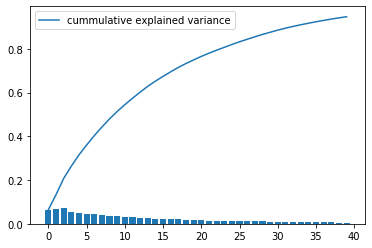

In [297]:
x = list(range(len(evr)))
plt.plot(x, np.cumsum(evr), label = "cummulative explained variance")
plt.bar(x, evr)
plt.legend()

#### Scree Plot
read about this in `Introduction to Statistical Learning` text

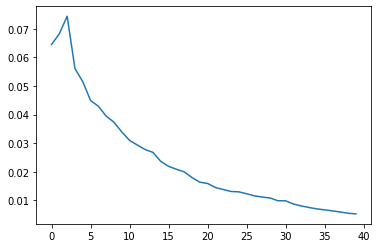

In [298]:
plt.plot(SVD.explained_variance_ratio_)

In [254]:
#svd_matrix[:4]

In [299]:
latent_semantic_analysis = pd.DataFrame(svd_matrix,
                                      index = document_term_matrix_df.index,
                                      columns = component_names)

latent_semantic_analysis['concat'] = train.concat
#latent_semantic_analysis.set_index(train.index)

In [300]:
latent_semantic_analysis.sample(4)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_32,component_33,component_34,component_35,component_36,component_37,component_38,component_39,component_40,concat
69,0.142185,0.491253,-0.098994,-0.049312,0.083268,-0.238681,0.385066,-0.188579,-0.063222,-0.348919,...,-0.152878,0.081787,-0.119241,0.219534,0.072632,0.000049,0.054153,-0.008647,-0.085180,F5-BIG-LTM-VE-10GV18 BIG-IP Virtual Edition: L...
37,0.109029,0.213271,0.047889,0.041447,-0.016837,0.156747,0.096552,-0.035229,0.046497,0.080783,...,-0.056100,-0.124566,0.076961,0.001451,0.053975,0.000075,0.027774,-0.027792,-0.027890,F5-BIG-VE-LAB-SP-V18 BIG-IP Virtual Edition: L...
81,0.028102,0.069669,0.154175,-0.091580,-0.098768,-0.050812,0.046487,-0.013752,-0.118374,0.236773,...,-0.113882,0.070936,0.085607,0.030273,0.055956,0.000321,-0.091556,-0.043505,-0.061613,F5-UTL-CS-DNS-MKT-01 Cloud Services: Marketpla...
30,0.797180,-0.270074,-0.013225,-0.060400,0.055886,0.006598,0.020965,0.010990,0.026763,0.000078,...,-0.008281,-0.013084,-0.007297,-0.005601,-0.020222,0.000057,0.040477,0.002689,-0.011147,F5-SBS-BIG-IPS-2-3YR BIG-IP Subscription: IPS ...


In [260]:
vocabulary_loadings = pd.DataFrame(SVD.components_,
                                   index=component_names,
                                   columns=tfidf_vectorizer.get_feature_names()).T

We take the absolute values of the principal components so that we could see the magnitude of explained variance. 

In [261]:
vocabulary_loadings['abs_component_1'] = np.abs(vocabulary_loadings.component_1)
vocabulary_loadings['abs_component_2'] = np.abs(vocabulary_loadings.component_2)

### Top 10 terms for each component

In [301]:
vocabulary_loadings.sort_values('abs_component_1', ascending = False).head(10)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,abs_component_1,abs_component_2
big,0.421050,0.013741,0.000724,0.005620,0.016094,0.020817,0.009184,-0.043025,-0.036566,-0.083580,...,0.184967,0.114082,0.088729,-0.019393,-0.012291,-0.013711,-0.025298,-0.022502,0.421050,0.013741
v18,0.387281,-0.116443,-0.042466,0.065558,-0.051221,-0.010904,-0.029458,0.053811,0.009288,0.069969,...,0.029424,0.006607,-0.024577,-0.009802,-0.001007,0.014064,-0.110908,-0.016865,0.387281,0.116443
ve,0.271604,0.012797,0.107829,0.240567,-0.037784,0.006440,-0.062767,0.127505,0.122648,-0.005462,...,-0.149857,-0.116225,-0.008996,0.014468,-0.008654,0.024339,0.050555,0.000578,0.271604,0.012797
edition,0.241625,-0.072286,0.029988,-0.012779,-0.008201,0.019726,-0.012917,0.020133,-0.064272,0.035018,...,0.012390,-0.001739,0.011727,0.003784,-0.023077,0.028557,0.047991,0.036497,0.241625,0.072286
virtual,0.241492,-0.073309,-0.098183,0.061898,0.059568,0.046744,-0.011254,-0.059393,-0.045370,0.017555,...,-0.012334,0.013667,0.004321,0.022918,-0.024893,0.028653,0.056931,0.049837,0.241492,0.073309
ip,0.222627,0.029017,0.037970,-0.000425,-0.019742,-0.009374,0.019210,-0.017292,-0.003547,-0.076567,...,0.040808,0.054479,0.044279,-0.006230,-0.018238,-0.009240,-0.006164,-0.004126,0.222627,0.029017
v12,0.219419,-0.072229,-0.265150,-0.091788,-0.061746,-0.010497,0.063156,-0.004928,0.045658,0.041302,...,-0.025359,0.046775,-0.037995,0.003872,0.011189,-0.010603,-0.041052,0.019688,0.219419,0.072229
gbps,0.206084,-0.067579,-0.214101,-0.022386,-0.008766,-0.161839,-0.013893,0.216256,0.173141,0.077435,...,0.021133,-0.020896,-0.058560,-0.004975,0.014674,0.005908,-0.016289,0.032812,0.206084,0.067579
f5,0.201401,0.073858,0.032145,-0.011696,-0.019253,-0.008958,0.021874,-0.032820,-0.016984,0.028443,...,-0.011709,0.020438,0.015729,-0.000951,0.007591,0.045949,0.021466,0.008118,0.201401,0.073858
manager,0.170879,-0.062510,-0.072040,-0.205226,0.326649,-0.206442,-0.012872,-0.002715,0.098592,0.039939,...,-0.071156,-0.024802,0.042021,0.023433,-0.011444,-0.012351,-0.021244,-0.091714,0.170879,0.062510


### Top 10 terms for component 2

In [302]:
vocabulary_loadings.sort_values('abs_component_2',ascending=False).head(10)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30,abs_component_1,abs_component_2
ips,0.074762,0.504179,-0.026165,-0.056567,0.012573,-0.003833,0.003688,0.002480,-0.025389,-0.049973,...,0.131077,0.014779,0.017662,-0.007849,0.018334,-0.022519,-0.053321,-0.042416,0.074762,0.504179
3yr,0.049509,0.347841,-0.014419,-0.050104,0.044980,0.008812,0.024131,0.019834,-0.018101,-0.010092,...,0.058771,0.003618,0.012344,-0.005050,0.014343,-0.013651,-0.035139,0.000677,0.049509,0.347841
sbs,0.050047,0.311508,-0.011499,-0.010920,0.003389,-0.000860,-0.009540,0.023332,0.006726,-0.066973,...,-0.037481,-0.015679,-0.006943,-0.000032,0.004090,-0.002450,0.000265,0.038321,0.050047,0.311508
signature,0.048921,0.303505,-0.006078,-0.009726,0.015892,0.001624,-0.001799,0.030184,0.015897,-0.078881,...,-0.039311,-0.005233,-0.029361,-0.015082,-0.019047,0.026671,-0.004124,-0.021041,0.048921,0.303505
subscription,0.050663,0.297700,0.002384,-0.005694,0.001371,-0.011806,0.013850,-0.007640,0.032662,-0.099636,...,-0.023215,0.014178,-0.004323,0.005116,-0.011454,-0.001236,-0.027904,-0.009152,0.050663,0.297700
1yr,0.043942,0.291047,-0.018458,-0.021982,-0.012760,-0.004859,-0.021706,0.000717,-0.016839,-0.038510,...,0.077348,0.014947,-0.006425,-0.024483,-0.007961,0.006726,-0.044640,-0.044893,0.043942,0.291047
license,0.053234,0.279260,-0.011630,-0.002614,0.004700,0.014085,0.004220,-0.007554,0.009672,0.075005,...,-0.031206,0.066396,0.041794,0.004616,0.036591,-0.053910,0.047522,-0.039551,0.053234,0.279260
vpr,0.014499,0.156262,-0.017545,-0.030425,0.007017,0.007636,0.002239,-0.047777,-0.056947,0.320913,...,-0.145344,-0.085959,-0.026003,0.035793,-0.010801,0.012192,0.085128,0.112729,0.014499,0.156262
series,0.012126,0.146128,-0.012880,-0.038651,0.019209,0.004027,0.009160,-0.012281,-0.036029,0.130090,...,-0.173326,-0.152060,-0.109985,0.032787,-0.040078,0.078191,0.142800,0.102385,0.012126,0.146128
viprion,0.012369,0.143495,-0.010807,-0.029474,0.023194,0.011050,0.012447,-0.040757,-0.046838,0.315665,...,-0.150791,-0.074510,-0.055350,0.017421,-0.040900,0.049979,0.081769,0.038678,0.012369,0.143495


(-0.1, 3)

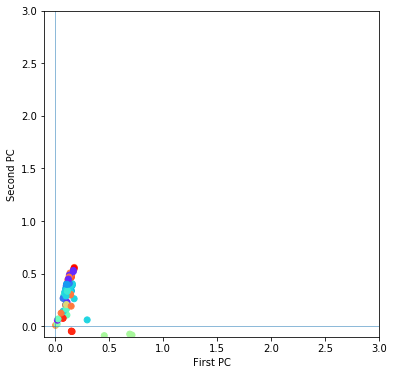

In [303]:
plt.figure(figsize=(6,6))
pc_1 = latent_semantic_analysis['component_1'].values
pc_2 = latent_semantic_analysis['component_2'].values

plt.scatter(pc_1, pc_2, c=train['product_numerical'], cmap='rainbow')
# made the colors represent different products 

plt.xlabel('First PC')
plt.ylabel('Second PC')
plt.axvline(linewidth=0.5)
plt.axhline(linewidth=0.5)
plt.xlim(-.1,3)
plt.ylim(-.1,3)

(-1, 4)

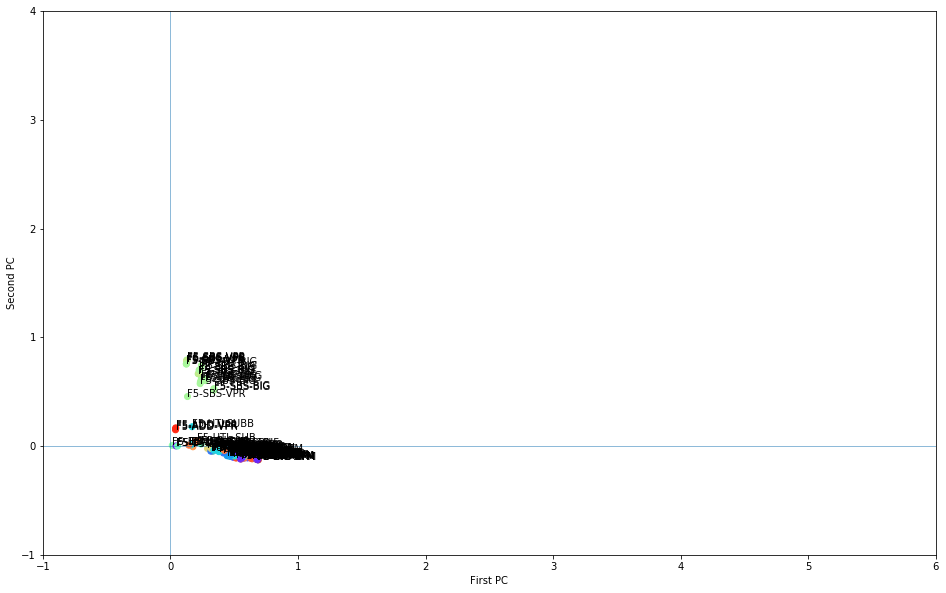

In [265]:
plt.figure(figsize=(16,10))
pc_1 = latent_semantic_analysis['component_1'].values
pc_2 = latent_semantic_analysis['component_2'].values

strings = train['concat'].values
for i, (x, y) in enumerate(zip(pc_1, pc_2)): 
    plt.text(x,y,strings[i][:10])

plt.scatter(pc_1, pc_2, c=train['product_numerical'], cmap='rainbow')

plt.xlabel('First PC')
plt.ylabel('Second PC')
plt.axvline(linewidth=0.5)
plt.axhline(linewidth=0.5)
plt.xlim(-1,6)
plt.ylim(-1,4)

### Modeling

In [266]:
from sklearn import pipeline


In [267]:
x = train.concat
y = train.index


In [187]:
KNN = KNeighborsClassifier()
gs = GridSearchCV(KNN, 
                  param_grid = {'n_neighbors': [11]}
                 )
gs.fit(x, y)

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


ValueError: n_splits=3 cannot be greater than the number of members in each class.